In [ ]:
!pip uninstall tensorflow

In [ ]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)


import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

import json

import keras # high level api to tensorflow (or theano, CNTK, etc.) and useful image preprocessing
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))
print('Keras image data format: {}'.format(K.image_data_format()))
print('Libraries successfully loaded')

In [ ]:
#Predefined Pathing to save the model and training history

DATA_FOLDER = os.path.join('images')
MODEL_PATH = os.path.join('model')
MODEL_FILE = os.path.join(MODEL_PATH, 'hand_recog_model.hdf5')
MODEL_HISTORY = os.path.join(MODEL_PATH, 'model_history.txt')
OUTPUT_TEXT = os.path.join('output', 'outputtext.txt')

In [ ]:
# Set up tracker.
def setup_tracker(ttype):
    #tracker_types = ['KCF', 'MEDIANFLOW', '']
    tracker_types = {
        'KCF': cv2.TrackerBoosting_create,
        'MEDIANFLOW': cv2.TrackerMedianFlow_create,
        'CSRT': cv2.TrackerCSRT_create,
        'MOSSE': cv2.TrackerMOSSE_create
    }
    tracker = tracker_types[ttype]()
    return tracker

In [42]:
#Neural Network
model = Sequential()

#First Layer
model.add(Conv2D(32, (5,5), input_shape = (54,54,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#2nd Layer
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#3rd Layer
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Full Connection
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [44]:
batch_size=30

#Image Augmentations
training_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen= ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'training_data',
    target_size=(54,54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation_data',
    target_size=(54,54),
    batch_size = batch_size,
    color_mode='grayscale'
)

Found 2709 images belonging to 9 classes.
Found 459 images belonging to 9 classes.


In [47]:
history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=10 // batch_size,
    workers=8,
)

#Save training history onto a .json file
history_dict = history.history
json.dump(history_dict, open(MODEL_HISTORY, 'w'))

Epoch 1/50
66/66 [==============================] - 10s 144ms/step - loss: 0.6371 - acc: 0.7796 - val_loss: 0.4424 - val_acc: 0.8606
Epoch 2/50
66/66 [==============================] - 14s 205ms/step - loss: 0.6424 - acc: 0.7773 - val_loss: 0.3723 - val_acc: 0.8758
Epoch 3/50
66/66 [==============================] - 17s 252ms/step - loss: 0.5744 - acc: 0.7953 - val_loss: 0.5389 - val_acc: 0.8039
Epoch 4/50
66/66 [==============================] - 16s 250ms/step - loss: 0.5579 - acc: 0.7936 - val_loss: 0.3631 - val_acc: 0.8824
Epoch 5/50
66/66 [==============================] - 14s 209ms/step - loss: 0.5867 - acc: 0.8023 - val_loss: 0.3214 - val_acc: 0.8889
Epoch 6/50
66/66 [==============================] - 13s 193ms/step - loss: 0.5293 - acc: 0.8172 - val_loss: 0.4315 - val_acc: 0.8627
Epoch 7/50
66/66 [==============================] - 13s 190ms/step - loss: 0.5985 - acc: 0.8037 - val_loss: 0.4228 - val_acc: 0.8540
Epoch 8/50
66/66 [==============================] - 15s 222ms/step - 

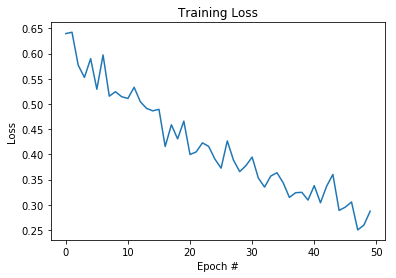

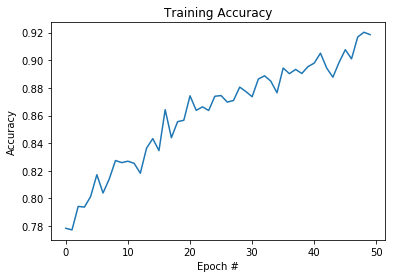

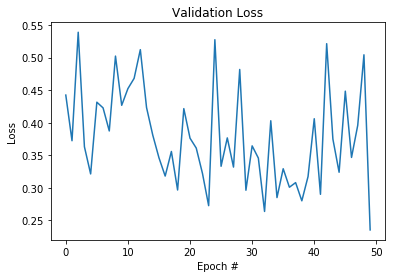

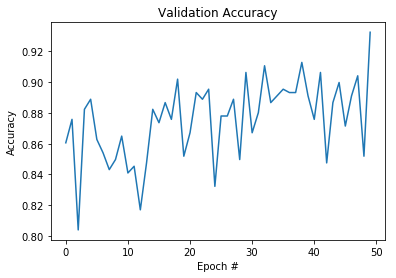

In [48]:
#Plot training history onto graph

history = json.load(open(MODEL_HISTORY, 'r'))

data = {}

data['acc'] = history['acc']
data['loss'] = history['loss']
data['val_acc'] = history['val_acc']
data['val_loss'] = history['val_loss']

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

In [49]:
#Save weights
#model.save(MODEL_FILE)

In [6]:
recog_model = load_model(MODEL_FILE, compile=False)

classes = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("ERROR: Could not open webcam")
    sys.exit()

#Resize video size
video.set(cv2.CAP_PROP_FRAME_WIDTH, 850)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, 850)


# Read first frame
success, frame = video.read()
if not success:
    print("ERROR: Cannot read video")
    sys.exit()

# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for image processing
kernel = np.ones((2,2),np.uint8)


# Display positions (pixel coordinates)
positions = {
    'hand_pose': (15, 40), # hand pose text
    'fps': (15, 20), # fps counter
    'null_pos': (200, 200) # used as null point for mouse control
}


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (116, 116, 170, 170) # Starting position for bounding box
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1

#List of texts to be saved in .txt file later.
textList = []

#Video loop   
while True:
    # Read a new frame
    success, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8) # Black screen to display data
    if not success:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing (Similar to data collection method)
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    th, thresh = cv2.threshold(gradient, 10, 255, cv2.THRESH_BINARY)
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(display)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = thresh[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        # Resize cropped hand and make prediction on gesture
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = recog_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() # Get the index of the greatest confidence
        gesture = classes[predi]
        
        for i, pred in enumerate(prediction[0]):
            # Draw confidence bar for each gesture
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx # calculate length of confidence bar
            
            # Make the most confidence prediction green
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
                
            """
            Coordinates for displaying FPS and predictions onto the frames
            """
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(gradient, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(gradient, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(gradient, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(gradient, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("Frame", display)
    # Display result
    cv2.imshow("Data", data_display)
    try:
        # Display hand_crop
        cv2.imshow("Hand", hand_crop)
    except:
        pass

    #Take key presses
    k = cv2.waitKey(1) & 0xff
    
    if k == 27 or k == 84: 
        #ESC Pressed then write contents of textList onto outputtext.txt
        f = open(OUTPUT_TEXT, 'w')
        txt = ' '.join(textList)
        f.write(txt)
        f.close()
        break
    elif k == 114 or k == 82: 
        # R pressed then reset video
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # T pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker('MEDIANFLOW')
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # S pressed then append predictions onto textList array
        textList.append(gesture)
        print(textList)
        
    #elif k != 255: print(k) #Debugging purposes

cv2.destroyAllWindows()
video.release()

In [76]:
cv2.destroyAllWindows()
video.release()